# Analysis of TCGA breast cancer dataset

In [8]:
import sofa 
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib
from sklearn.preprocessing import StandardScaler
from muon import MuData
import warnings
warnings.filterwarnings('ignore')

In [9]:
torch.manual_seed(0)

In [10]:
# read data
rna = pd.read_csv("data/tcga_data/train_rna.csv", index_col=0)
mirna = pd.read_csv("data/tcga_data/train_mirna.csv", index_col=0)
prot = pd.read_csv("data/tcga_data/train_prot.csv", index_col=0)
meth = pd.read_csv("data/tcga_data/train_meth.csv", index_col=0)
subtype = pd.read_csv("data/tcga_data/train_y.csv", index_col=0)

# scale and center train data 
scaler = StandardScaler()
rna = pd.DataFrame(scaler.fit_transform(rna), columns = rna.columns)
meth = pd.DataFrame(scaler.fit_transform(meth), columns = meth.columns)
mirna = pd.DataFrame(scaler.fit_transform(mirna), columns = mirna.columns)
prot = pd.DataFrame(scaler.fit_transform(prot), columns = prot.columns)

# all views have gaussian distribution
data = [rna, meth, mirna, prot]
llh = ["gaussian", "gaussian", "gaussian", "gaussian"]
views = ["mrna", "methylation", "mirna", "proteomics"]


In [11]:

adata = [sofa.tl.get_ad(data[i], llh[i]) for i in range(len(data))]
Xmdata = MuData({views[i]:adata[i] for i in range(len(adata))})
Xmdata

MuData object with n_obs × n_vars = 379 × 4326
  4 modalities
    mrna:	379 x 2000
      uns:	'llh'
      obsm:	'mask'
    methylation:	379 x 2000
      uns:	'llh'
      obsm:	'mask'
    mirna:	379 x 184
      uns:	'llh'
      obsm:	'mask'
    proteomics:	379 x 142
      uns:	'llh'
      obsm:	'mask'

In [12]:
subtype_ad = sofa.tl.get_ad(subtype, "multinomial")
Ymdata = MuData({"subtype":subtype_ad})

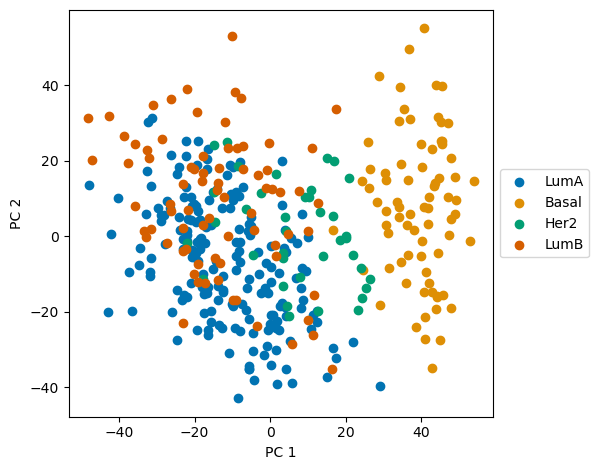

In [13]:

# convert string labels to numeric
label_map = {lab:i for i,lab in enumerate(np.unique(subtype["x"]))}
y = np.array([label_map[i] for i in subtype["x"]])

# define colors for target classes
cblind_colors = sns.color_palette("colorblind", as_cmap=True)[0:4]
subtypes = ["LumA", "Basal",  "Her2", "LumB"]

# plot pca of concatenated views
pca = PCA(2).fit_transform(np.hstack(data))
fig, ax = plt.subplots(1)
for i,sub in enumerate(subtypes):
    plot = ax.scatter(pca[subtype["x"].values==sub,0],pca[subtype["x"].values==sub,1], color=cblind_colors[i], label=sub)
ax.set_aspect('equal')
ax.set_aspect('equal')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
plt.close()


In [14]:
num_factors = 5
design = np.zeros((len(Ymdata.mod), num_factors))
design[0,0:2] = 1
design

array([[1., 1., 0., 0., 0.]])

In [17]:
# set up model and fit
model = sofa.SOFA(Xmdata, 
            num_factors=5, 
            Ymdata=Ymdata, 
            design= torch.tensor(design),
            device=torch.device('cpu'),
            ard=False,
            horseshoe=True)

In [18]:
# fit and plot loss
model.fit(n_steps=1000, lr=0.01)

Current Elbo 3.95E+06 | Delta: 2994147: 100%|██████████| 1000/1000 [03:42<00:00,  4.49it/s]


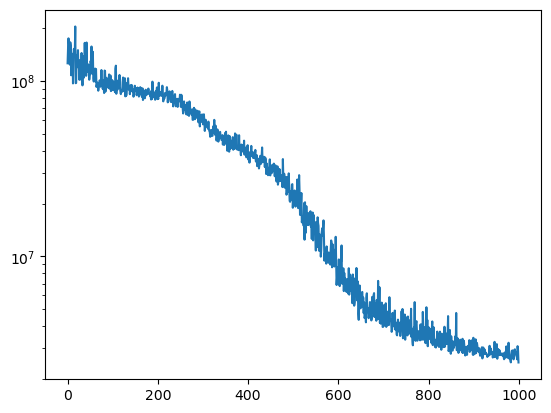

In [19]:
plt.semilogy(model.history)
plt.show()
plt.close()

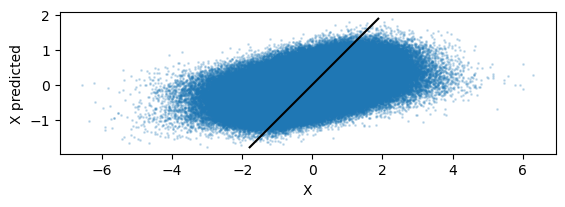

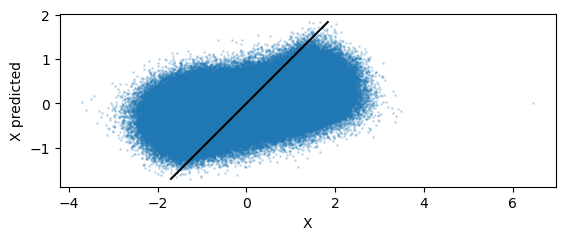

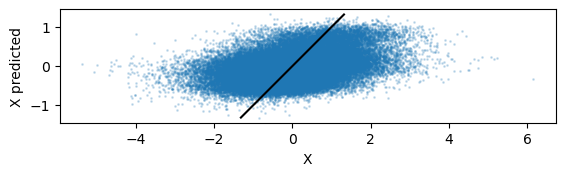

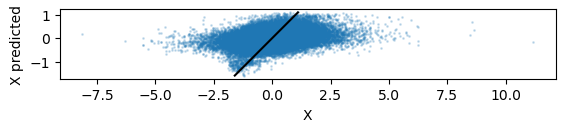

In [21]:
# plot fits
sofa.pl.plot_fit(model, view=0)
plt.show()
plt.close()
sofa.pl.plot_fit(model, view=1)
plt.show()
plt.close()
sofa.pl.plot_fit(model, view=2)
plt.show()
plt.close()
sofa.pl.plot_fit(model, view=3)
plt.show()
plt.close()

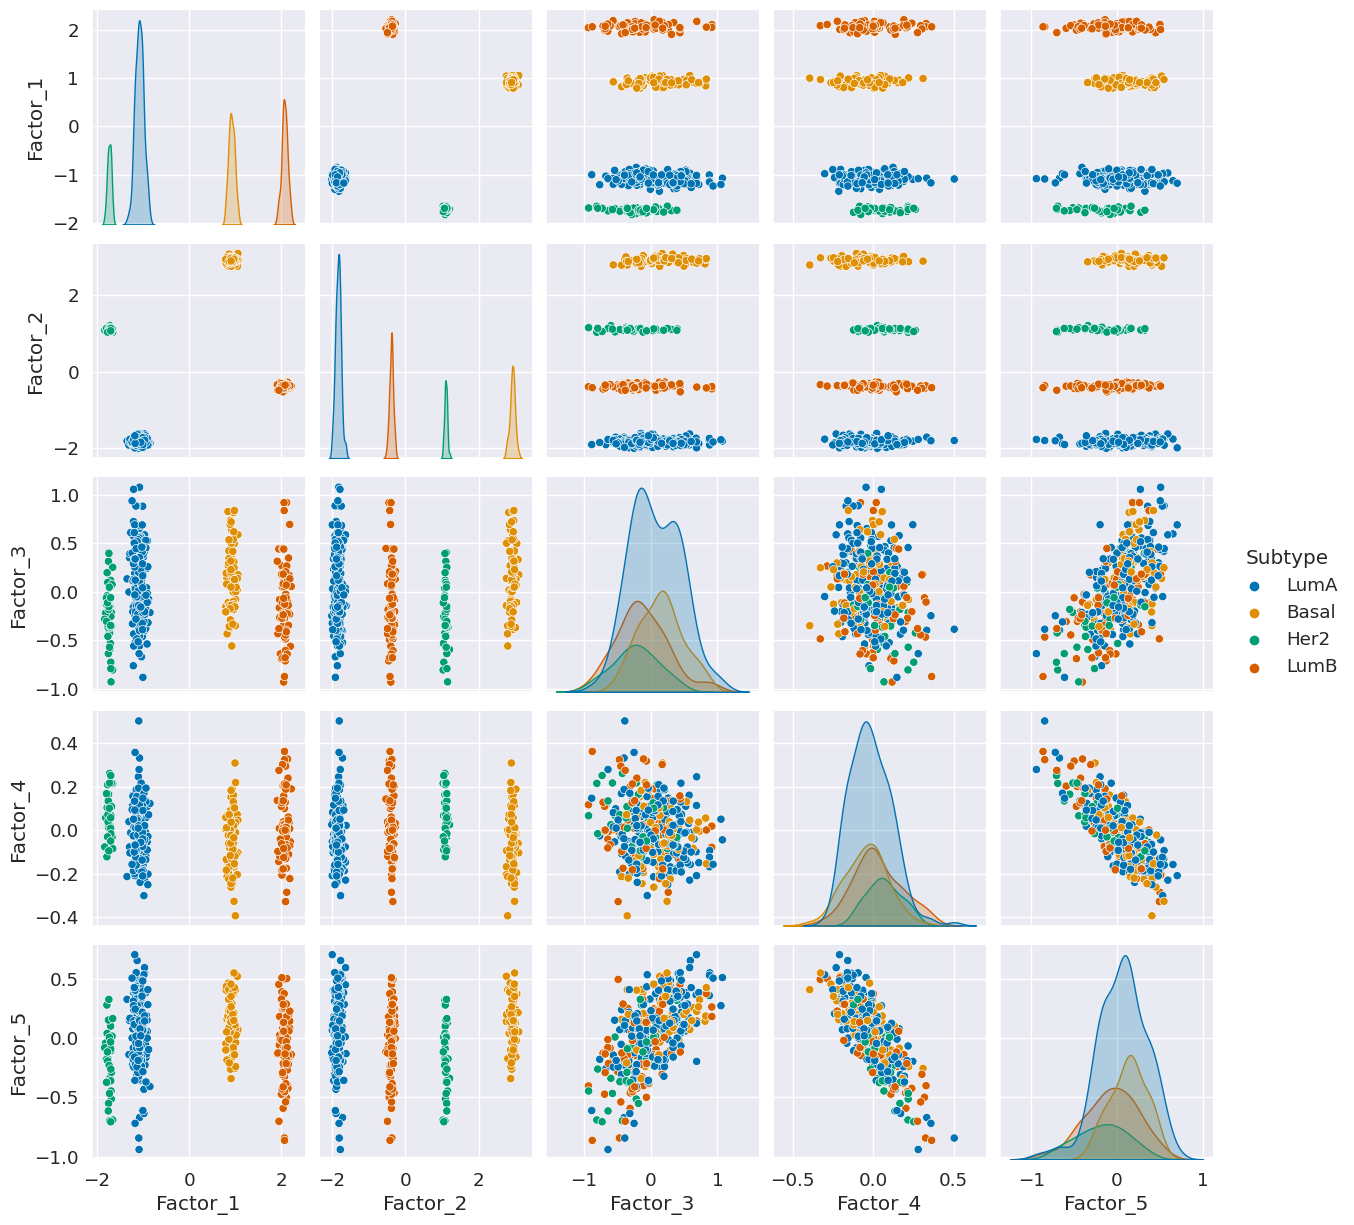

In [23]:
Z_pred = model.Z

df = pd.DataFrame(Z_pred, columns=[f"Factor_{i+1}" for i in range(Z_pred.shape[1])])
df["Subtype"] = subtype["x"].values

# pair plot of all factors colored according to subtype
sns.set_theme(font_scale=1.2)
sns.pairplot(df, vars=df.columns[:-1], hue="Subtype", palette="colorblind")
plt.show()
plt.close()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


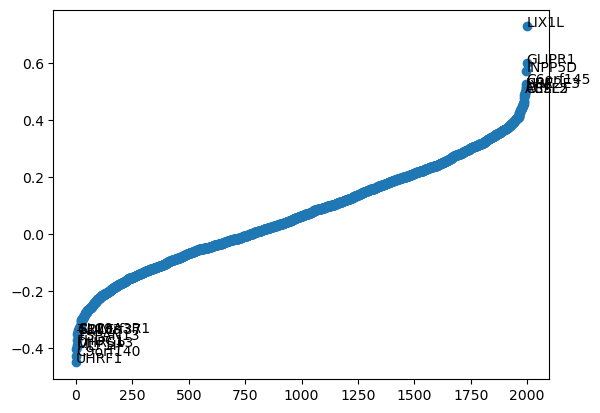

In [25]:

sofa.pl.plot_weights(model, view=0, factor=4)
plt.show()


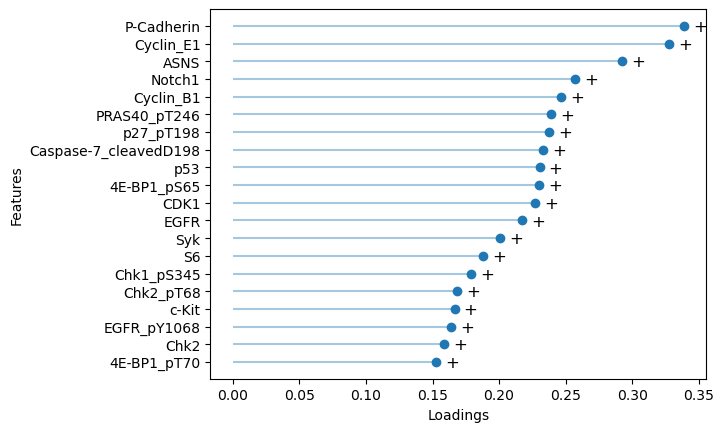

In [26]:
# plot top 20 weights of factor 1 and proteomics data (factor 0 corresponds to the first factor)
sofa.pl.plot_top_weights(model, view=3, factor=1,top_n=20 ,sign="+")
plt.show()

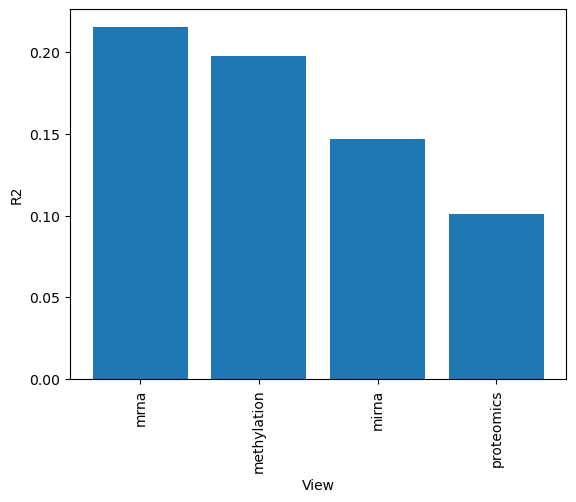

In [27]:

sofa.pl.plot_variance_explained_view(model)
plt.show()


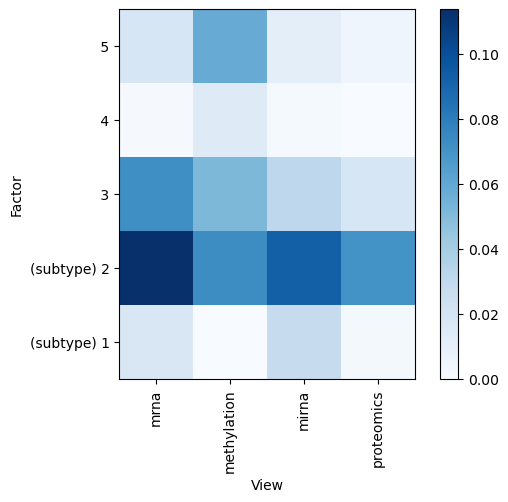

In [28]:

sofa.pl.plot_variance_explained(model)
plt.show()
